# 1. Set Up Environments

## Spark

In [ ]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Download Spark
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
# Unzip the file
!tar xf spark-3.5.0-bin-hadoop3.tgz
# Set up the enviornment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.5.0-bin-hadoop3'
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,StringType

## Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# https://drive.google.com/file/d/142onsA72meq-7g02yOauJ6vWUZ8MxM43/view?usp=sharing
id = "142onsA72meq-7g02yOauJ6vWUZ8MxM43"
file = drive.CreateFile({'id':id})
file.GetContentFile('kaggle.json')

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hernan4444/anime-recommendation-database-2020
!unzip anime-recommendation-database-2020.zip

 99% 654M/661M [00:05<00:00, 75.3MB/s]
100% 661M/661M [00:05<00:00, 123MB/s] 
Archive:  anime-recommendation-database-2020.zip
  inflating: anime.csv               
  inflating: anime_with_synopsis.csv  
  inflating: animelist.csv           
  inflating: html folder/html/1/details.html  
  inflating: html folder/html/1/pictures.html  
  inflating: html folder/html/1/recomendations.html  
  inflating: html folder/html/1/reviews_1.html  
  inflating: html folder/html/1/reviews_10.html  
  inflating: html folder/html/1/reviews_11.html  
  inflating: html folder/html/1/reviews_12.html  
  inflating: html folder/html/1/reviews_13.html  
  inflating: html folder/html/1/reviews_14.html  
  inflating: html folder/html/1/reviews_15.html  
  inflating: html folder/html/1/reviews_16.html  
  inflating: html folder/html/1/reviews_17.html  
  inflating: html folder/html/1/reviews_18.html  
  inflating: html folder/html/1/reviews_19.html  
  inflating: html folder/html/1/reviews_2.html  
  inflating

## Datasets

In [ ]:
ratings_df = spark.read.load("rating_complete.csv", format='csv', header = True)

In [ ]:
ratings_df = ratings_df.limit(1000000)
ratings_df.count()

1000000

In [ ]:
animes_df = spark.read.load("anime.csv", format='csv', header = True)
animes_df = animes_df.withColumnRenamed("MAL_ID", "anime_id")
animes_df.show(5)

+--------+--------------------+-----+--------------------+--------------------+---------------------------+-----+--------+--------------------+-----------+--------------------+--------------------+--------------+--------+---------------+--------------------+------+----------+-------+---------+--------+---------+-------+-------+-------------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+
|anime_id|                Name|Score|              Genres|        English name|              Japanese name| Type|Episodes|               Aired|  Premiered|           Producers|           Licensors|       Studios|  Source|       Duration|              Rating|Ranked|Popularity|Members|Favorites|Watching|Completed|On-Hold|Dropped|Plan to Watch|Score-10| Score-9| Score-8|Score-7|Score-6|Score-5|Score-4|Score-3|Score-2|Score-1|
+--------+--------------------+-----+--------------------+--------------------+---------------------------+-----+--------+--------------------+---

In [ ]:
ratings_df.show(5)

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      0|     430|     9|
|      0|    1004|     5|
|      0|    3010|     7|
|      0|     570|     7|
|      0|    2762|     9|
+-------+--------+------+
only showing top 5 rows



In [ ]:
tmp1 = ratings_df.groupBy("user_id").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("anime_id").count().toPandas()['count'].min()
print('Minimum number of recs per user is {}.'.format(tmp1))
print('Minimum number of recs per anime is {}.'.format(tmp2))

Minimum number of recs per user is 1.
Minimum number of recs per anime is 1.


In [ ]:
tmp1 = sum(ratings_df.groupBy("anime_id").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('anime_id').distinct().count()
print('{} out of {} animes are rated by only one user.'.format(tmp1, tmp2))

1737 out of 12155 animes are rated by only one user.


# 2. OLAP

In [ ]:
ratings_df.registerTempTable("ratings")
animes_df.registerTempTable("animes")

/content/spark-3.5.0-bin-hadoop3/python/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
nuser=spark.sql('SELECT COUNT(DISTINCT user_id) ' +\
                'FROM ratings'
                ).toPandas()
print('Total number of users is ',nuser.iloc[0,0])

Total number of users is  5616


In [ ]:
genre_sep=udf(lambda x: x.split(', '),ArrayType(StringType()))
spark.udf.register('genre_sep',genre_sep)
spark.sql('SELECT DISTINCT genres_listTable ' +
          'FROM (SELECT EXPLODE(genre_sep(Genres)) AS genres_listTable FROM animes) temp ' +
          'WHERE genres_listTable IS NOT NULL AND genres_listTable != "" ' +
          'AND genres_listTable RLIKE "^[a-zA-Z]+$" ' +
          'ORDER BY 1').show()

+----------------+
|genres_listTable|
+----------------+
|          Action|
|       Adventure|
|            Cars|
|          Comedy|
|        Dementia|
|          Demons|
|           Drama|
|           Ecchi|
|         Fantasy|
|            Game|
|           Harem|
|          Hentai|
|      Historical|
|          Horror|
|           Josei|
|            Kids|
|           Magic|
|           Mecha|
|        Military|
|           Music|
+----------------+
only showing top 20 rows



In [ ]:
anime_by_genre=spark.sql('SELECT Name, category ' +\
                         'FROM animes ' +\
                         'LATERAL VIEW EXPLODE(genre_sep(Genres)) AS category')
anime_by_genre.createOrReplaceTempView('anime_by_genre')
cat_num = spark.sql('SELECT category, COUNT(*) AS number ' +\
          'FROM anime_by_genre  ' +\
          'GROUP BY category  ' +\
          'ORDER BY 2 DESC')
cat_num.show()

+-------------+------+
|     category|number|
+-------------+------+
|       Comedy|  6027|
|       Action|  3888|
|      Fantasy|  3285|
|    Adventure|  2957|
|         Kids|  2664|
|        Drama|  2617|
|       Sci-Fi|  2583|
|        Music|  2244|
|      Shounen|  2003|
|Slice of Life|  1914|
|      Romance|  1899|
|       School|  1642|
| Supernatural|  1479|
|       Hentai|  1347|
|   Historical|  1144|
|        Mecha|  1101|
|        Magic|  1081|
|       Seinen|   830|
|        Ecchi|   767|
|      Mystery|   725|
+-------------+------+
only showing top 20 rows



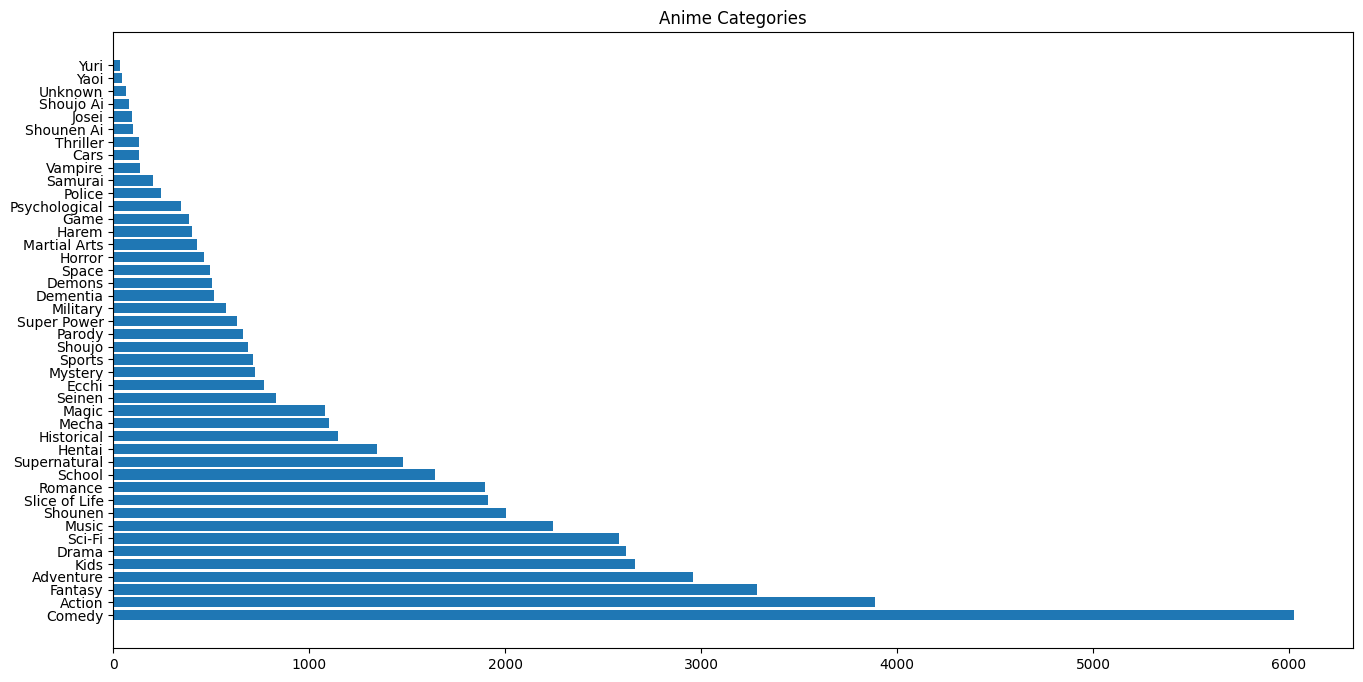

In [ ]:
plt.figure(figsize=[16,8])
plt.barh(y='category',width='number',data=cat_num.toPandas().iloc[:-3,:])
plt.title('Anime Categories')
plt.show()

# 3. Spark ALS Model

## Datasets

In [ ]:
ratings_df.show()

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      0|     430|     9|
|      0|    1004|     5|
|      0|    3010|     7|
|      0|     570|     7|
|      0|    2762|     9|
|      0|     431|     8|
|      0|     578|    10|
|      0|     433|     6|
|      0|    1571|    10|
|      0|     121|     9|
|      0|     356|     9|
|      0|    1250|     7|
|      0|    2913|     6|
|      0|    1689|     6|
|      0|      68|     6|
|      0|    1829|     7|
|      0|     600|     6|
|      0|    3418|     9|
|      0|     164|     8|
|      0|    1894|     7|
+-------+--------+------+
only showing top 20 rows



In [ ]:
from pyspark.sql.types import IntegerType, FloatType

anime_ratings = ratings_df.select(*ratings_df.columns)
anime_ratings = anime_ratings.withColumn("user_id", anime_ratings["user_id"].cast(IntegerType()))
anime_ratings = anime_ratings.withColumn("anime_id", anime_ratings["anime_id"].cast(IntegerType()))
anime_ratings = anime_ratings.withColumn("rating", anime_ratings["rating"].cast(FloatType()))
anime_ratings.show()

+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      0|     430|   9.0|
|      0|    1004|   5.0|
|      0|    3010|   7.0|
|      0|     570|   7.0|
|      0|    2762|   9.0|
|      0|     431|   8.0|
|      0|     578|  10.0|
|      0|     433|   6.0|
|      0|    1571|  10.0|
|      0|     121|   9.0|
|      0|     356|   9.0|
|      0|    1250|   7.0|
|      0|    2913|   6.0|
|      0|    1689|   6.0|
|      0|      68|   6.0|
|      0|    1829|   7.0|
|      0|     600|   6.0|
|      0|    3418|   9.0|
|      0|     164|   8.0|
|      0|    1894|   7.0|
+-------+--------+------+
only showing top 20 rows



In [ ]:
anime_ratings.describe().show()

+-------+------------------+------------------+------------------+
|summary|           user_id|          anime_id|            rating|
+-------+------------------+------------------+------------------+
|  count|           1000000|           1000000|           1000000|
|   mean|       3231.437798|      15840.059475|          7.546965|
| stddev|1884.6999471164768|13240.849621290718|1.6752059858686512|
|    min|                 0|                 1|               1.0|
|    max|              6434|             48456|              10.0|
+-------+------------------+------------------+------------------+



In [ ]:
anime_ratings.select('user_id').distinct().count()

5616

In [ ]:
anime_ratings.select('anime_id').distinct().count()

12155

<Axes: title={'center': 'Ratings Distribution'}, xlabel='rating', ylabel='Count'>

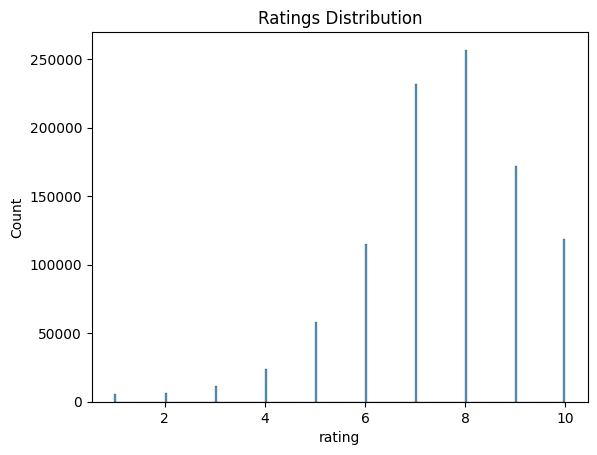

In [ ]:
plt.title('Ratings Distribution')
sns.histplot(data=anime_ratings.toPandas(), x='rating')

## ALS Model Selection

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [ ]:
(training,test) = anime_ratings.randomSplit([0.8,0.2])
model_als = ALS(maxIter=5, rank=3, regParam=0.01, userCol="user_id", itemCol="anime_id", ratingCol="rating",
          coldStartStrategy="drop", seed=6)

In [ ]:
#Tune model using ParamGridBuilder
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [15, 20])\
            .addGrid(model_als.regParam, [0.1, 0.05])\
            .addGrid(model_als.alpha, [1, 0.5])\
            .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


# Build Cross validation
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=3, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

# Check the best parameters
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 20
-> regParam: 0.1
-> alpha: 1.0


In [ ]:
#Extract best model from the tuning exercise using ParamGridBuilder
prediction_train=cvModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 1.12583823904355


## Model Testing

In [ ]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())),
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))
print (" Alpha: ", str(bestModel._java_obj.parent().getAlpha()))

RMSE = 1.2016915709670777
**Best Model**
 Rank:  3
 MaxIter:  20
 RegParam:  0.1
 Alpha:  1.0


In [ ]:
predictions.show()

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
|      0|     121|   9.0| 7.8304367|
|      0|     415|  10.0|  6.213599|
|      0|    1689|   6.0|  7.385298|
|      0|    1829|   7.0|  7.179881|
|      0|    2236|  10.0|  7.878737|
|      0|    2248|   6.0|  6.625986|
|      0|    2547|   7.0| 7.4378424|
|      0|    3010|   7.0|  6.980242|
|      1|    5081|   8.0|  8.462769|
|      1|    6325|   7.0| 7.0528073|
|      1|   11577|  10.0|  8.476278|
|      1|   14813|   8.0|  7.985963|
|      1|   16894|   7.0|  8.277901|
|      1|   18689|   8.0|   8.24232|
|      1|   18753|   7.0|  7.464221|
|      1|   19815|   8.0|   7.99089|
|      1|   28171|   8.0|   8.27924|
|      1|   28851|   9.0|  9.039779|
|      1|   30831|   7.0|  8.008764|
|      1|   31043|   9.0|  8.299759|
+-------+--------+------+----------+
only showing top 20 rows



## Model Apply and Performance

In [ ]:
alldata = bestModel.transform(anime_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 1.1413648606408018


In [ ]:
alldata.registerTempTable("alldata")

/content/spark-3.5.0-bin-hadoop3/python/pyspark/sql/dataframe.py:329: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [ ]:
spark.sql("Select * From alldata").show()

+-------+--------+------+----------+
|user_id|anime_id|rating|prediction|
+-------+--------+------+----------+
|      0|     430|   9.0| 7.5046844|
|      0|    1004|   5.0| 7.0918083|
|      0|    3010|   7.0|  6.980242|
|      0|     570|   7.0|  7.069558|
|      0|    2762|   9.0|  8.044738|
|      0|     431|   8.0| 8.1034355|
|      0|     578|  10.0|  7.783364|
|      0|     433|   6.0| 7.6950927|
|      0|    1571|  10.0|  7.572386|
|      0|     121|   9.0| 7.8304367|
|      0|     356|   9.0|  7.324508|
|      0|    1250|   7.0| 7.0862827|
|      0|    2913|   6.0| 6.5910883|
|      0|    1689|   6.0|  7.385298|
|      0|      68|   6.0| 7.1770926|
|      0|    1829|   7.0|  7.179881|
|      0|     600|   6.0| 5.5921984|
|      0|    3418|   9.0|  8.416864|
|      0|     164|   8.0|  7.994555|
|      0|    1894|   7.0|  6.526926|
+-------+--------+------+----------+
only showing top 20 rows



In [ ]:
spark.sql('SELECT * ' +\
          'FROM animes ' +\
	          'JOIN alldata ON animes.anime_id = alldata.anime_id').show()

+--------+--------------------+-----+--------------------+--------------------+--------------------------------------+-----+--------+--------------------+-----------+--------------------+--------------------+--------------------+------------+---------------+--------------------+-------+----------+-------+---------+--------+---------+-------+-------+-------------+--------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+--------+------+----------+
|anime_id|                Name|Score|              Genres|        English name|                         Japanese name| Type|Episodes|               Aired|  Premiered|           Producers|           Licensors|             Studios|      Source|       Duration|              Rating| Ranked|Popularity|Members|Favorites|Watching|Completed|On-Hold|Dropped|Plan to Watch|Score-10| Score-9| Score-8| Score-7|Score-6|Score-5|Score-4|Score-3|Score-2|Score-1|user_id|anime_id|rating|prediction|
+--------+--------------------

## Recommend Anime to User

In [ ]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  '''
  k: the number of animes to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  # the table for all top10 recommendations
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.user_id==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['anime_id','predicted_ratings'])
  temp=None
  for i in user_recommd['anime_id']:
    if not temp:
      temp=animes_df.where(animes_df.anime_id==str(i))
    else:
      temp=temp.union(animes_df.where(animes_df.anime_id==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  out = pd.concat([out['predicted_ratings'], out.drop(columns=['predicted_ratings'])], axis=1)
  out.drop(columns = out.columns[-10:],inplace=True)
  return out


topKRecommend(10,1,bestModel)

,predicted_ratings,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,...,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
1,9.997963,33548,Babyshiba,5.68,Comedy,Unknown,ベビしば,Special,7,"2011 to Feb 20, 2020",...,G - All Ages,9207.0,12230,482,0,11,296,14,41,120
2,9.913454,820,Ginga Eiyuu Densetsu,9.07,"Military, Sci-Fi, Space, Drama",Legend of the Galactic Heroes,銀河英雄伝説,OVA,110,"Jan 8, 1988 to Mar 17, 1997",...,R - 17+ (violence & profanity),7.0,633,230168,13834,25968,52583,14911,5950,130756
3,9.905538,42104,Gisoku no Moses,6.48,"Music, Supernatural",Unknown,義足のMoses,Music,1,"Sep 15, 2013",...,G - All Ages,5993.0,15172,185,2,2,166,1,1,15
4,9.861882,40587,Precure Miracle Leap Movie: Minna to no Fushig...,6.97,"Action, Fantasy, Magic, Shoujo",Unknown,映画プリキュアミラクルリープ みんなとの不思議な1日,Movie,1,"Oct 31, 2020",...,G - All Ages,3732.0,9677,1439,4,28,286,23,28,1074
5,9.834964,33549,Mame-Mofu Collab Animation,5.51,Comedy,Unknown,豆モフコラボアニメーシヨン,ONA,1,2008,...,G - All Ages,9681.0,12786,382,0,10,215,13,38,106
6,9.811899,28587,Modern,5.06,Dementia,Unknown,MODERN,Movie,1,2010,...,G - All Ages,10529.0,11708,592,0,8,453,6,21,104
7,9.811899,19231,Jam,4.83,"Music, Dementia, Fantasy",Unknown,JAM,Music,1,2009,...,G - All Ages,10751.0,11289,708,1,11,584,4,23,86
8,9.725458,39486,Gintama: The Final,8.88,"Action, Sci-Fi, Comedy, Historical, Parody, Dr...",Unknown,銀魂 THE FINAL,Movie,1,"Jan 8, 2021",...,PG-13 - Teens 13 or older,19.0,2987,29811,902,1465,2640,363,127,25216
9,9.687181,6658,Unko-san: Tsuiteru Hito ni Shika Mienai Yousei,5.35,"Comedy, Magic",Unknown,うんこさん ツイてる人にしか見えない妖精,TV,13,"Mar 18, 2009 to Jul 20, 2009",...,PG - Children,10059.0,11544,630,0,39,145,27,128,291
10,9.684940,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",...,R - 17+ (violence & profanity),2.0,119,733260,44862,566239,553,6658,2090,157720


## Find Similar Anime

In [ ]:
# access the anime factor matrix
anime_factors=bestModel.itemFactors
anime_factors.printSchema()
comd=["anime_factors.selectExpr('id as anime_id',"]
for i in range(bestModel.rank):
  if i<bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
anime_factors=eval(''.join(comd))
anime_factors.createOrReplaceTempView('anime_factors')
anime_factors.show()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+--------+----------+------------+---------+
|anime_id|  feature0|    feature1| feature2|
+--------+----------+------------+---------+
|      20|-2.1277092|  0.68452996|1.6622198|
|      30|-2.5180597| -0.38406634|1.8295298|
|      50|-1.4042178|   0.6463099|2.0325708|
|      60|-1.9516193|   0.7689254|1.7565758|
|      80| -2.470847|  0.04924053| 1.609769|
|      90|-1.8573298|   0.6414743|1.9505315|
|     100|  -1.64909|   1.1359538|1.5627209|
|     110|-2.0504954|   0.5633836|1.6849251|
|     120|-1.8010101|   0.6471438|1.8491751|
|     130|-2.0721552|  0.67289895|1.5921729|
|     150|-1.9594846|   0.7041516| 1.794246|
|     160|-2.3473966|-9.904025E-4|1.7018836|
|     170|  -2.46312| 0.028636694|1.8711846|
|     180|-1.4442654|   0.9402968|1.8916358|
|     190|-1.1597747|   0.9442097|2.1668253|
|     200|-1.8460441|  0.37175155|2.0336535|
|     210|-1.974

In [ ]:
# method 1: Euclidean distance based similarity
def dist_similar(k,mid):
  '''
  k: number of similar animes to find
  mid: id of the anime to find similarities
  '''
  anime_info=spark.sql('select * from anime_factors where anime_id='+str(mid)).toPandas()
  if anime_info.shape[0]<=0:
    print('No anime with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select anime_id,']
  for i in range(bestModel.rank):
    val=anime_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<bestModel.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from anime_factors where anime_id!='+str(mid))
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('anime_id','sd0+sd1+sd2 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['anime_id']:
    if not out:
      out=animes_df.where(animes_df.anime_id==str(i))
    else:
      out=out.union(animes_df.where(animes_df.anime_id==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  out.drop(columns = out.columns[-10:],inplace=True)
  return out, ssd

In [ ]:
# # method 2: cosine similarity
# def cos_similar(k,mid):
#   '''
#   k: number of similar animes to find
#   mid: id of the anime to find similarities
#   '''
#   anime_info=spark.sql('select * from anime_factors where anime_id='+str(mid)).toPandas()
#   if anime_info.shape[0]<=0:
#     print('No anime with id '+str(mid)+' is found in the data.')
#     return None, None
#   norm_m=sum(anime_info.iloc[0,1:].values**2)**0.5
#   temp=['select anime_id,']
#   norm_str=['sqrt(']
#   for i in range(bestModel.rank):
#     comd='feature'+str(i)+'*'+str(anime_info.iloc[0,i+1])
#     temp.append(comd+' as inner'+str(i)+',')
#     if i<bestModel.rank-1:
#       norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
#     else:
#       norm_str.append('feature'+str(i)+'*feature'+str(i))
#   norm_str.append(') as norm')
#   temp.append(''.join(norm_str))
#   temp.append(' from anime_factors where anime_id!='+str(mid))
#   inner=spark.sql(' '.join(temp))
#   inner=inner.selectExpr('anime_id',\
#                          '(inner0+inner1+inner2)/norm/'+str(norm_m)+' as innerP').\
#                          orderBy('innerP',ascending=False).limit(k).toPandas()
#   out=None
#   for i in inner['anime_id']:
#     if not out:
#       out=animes_df.where(animes_df.anime_id==str(i))
#     else:
#       out=out.union(animes_df.where(animes_df.anime_id==str(i)))
#   out=out.toPandas()
#   out.index=range(1,k+1)
#   out.drop(columns = out.columns[-10:],inplace=True)
#   return out, inner

In [ ]:
# top = 5
# aid = 20
# out,inner=cos_similar(top,aid)
# print(f'Top {top} similar animes to {animes_df.filter(animes_df["anime_id"] == aid).select("Japanese name").collect()[0]["Japanese name"]}:')
# out

In [ ]:
top = 5
aid = 20

out,inner=dist_similar(top,aid)
print(f'Top {top} similar anime to {animes_df.filter(animes_df["anime_id"] == aid).select("Japanese name").collect()[0]["Japanese name"]}:')
out

Top 5 similar anime to ナルト:


,anime_id,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
1,8514,Break Blade 2: Ketsubetsu no Michi,7.75,"Action, Fantasy, Mecha, Military, Shounen",Broken Blade 2,ブレイクブレイド 訣別ノ路,Movie,1,"Jun 26, 2010",Unknown,...,R - 17+ (violence & profanity),923.0,2060,57276,27,534,49205,318,195,7024
2,6444,Tegamibachi,7.65,"Adventure, Supernatural, Fantasy, Shounen",Tegami Bachi:Letter Bee,テガミバチ,TV,25,"Oct 3, 2009 to Mar 27, 2010",Fall 2009,...,PG-13 - Teens 13 or older,1148.0,1357,103916,782,6231,47679,6395,5903,37708
3,1486,Kodomo no Omocha (TV),8.04,"Comedy, Drama, Romance, Shoujo",Kodocha,こどものおもちゃ,TV,102,"Apr 5, 1996 to Mar 27, 1998",Spring 1996,...,PG-13 - Teens 13 or older,491.0,2285,49188,1111,3536,22988,4927,3580,14157
4,37869,BanG Dream! 2nd Season,7.59,Music,Unknown,BanG Dream!（バンドリ！）第2期,TV,13,"Jan 3, 2019 to Mar 28, 2019",Winter 2019,...,PG-13 - Teens 13 or older,1306.0,3095,27967,412,2235,15787,841,1035,8069
5,957,Saiunkoku Monogatari,7.94,"Adventure, Comedy, Drama, Fantasy, Historical,...",The Story of Saiunkoku,彩雲国物語,TV,39,"Apr 8, 2006 to Feb 24, 2007",Spring 2006,...,PG-13 - Teens 13 or older,623.0,1677,79685,1186,5702,35803,5003,3975,29202


## Find Similar Users

In [ ]:
# access the user factor matrix
user_factors=bestModel.userFactors
user_factors.printSchema()
comd=["user_factors.selectExpr('id as user_id',"]
for i in range(bestModel.rank):
  if i<bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
user_factors=eval(''.join(comd))
user_factors.createOrReplaceTempView('user_factors')
user_factors.show()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+----------+-----------+---------+
|user_id|  feature0|   feature1| feature2|
+-------+----------+-----------+---------+
|      0|-1.6551893|   0.960991|2.0029519|
|     10|-1.6256915|-0.58096343| 2.540024|
|     20|-2.1059556|  0.3793684|1.9054576|
|     30|-1.1894776|  1.1555476|2.2121267|
|     40|  -1.72558| 0.97494936| 2.410203|
|     50| -2.287674|  1.0154909|1.4708419|
|     70|-1.8941176| 0.16345747|1.7714578|
|     80|-2.1077907|  0.4987558|1.9543378|
|     90|-2.2461884| 0.65986276|2.0443568|
|    110|-1.8102409|  1.1637928|2.7055497|
|    120| -1.954856|  1.7558557|2.6704712|
|    130|-1.9476491|  1.7065022| 2.673875|
|    150|-2.4732518| 0.99101293|1.6358964|
|    160|-1.9794515|  1.0296916|1.8419101|
|    170|-1.8889861|  1.0413419|1.9393209|
|    190|-2.1884487|  1.4605225| 2.205869|
|    210|-2.1311314| 0.36608398|1.7157235|
|    220|-2

In [ ]:
def dist_similar_user(k,mid):
  '''
  k: number of similar users to find
  mid: id of the user to find similarities
  '''
  user_info=spark.sql('select * from user_factors where user_id='+str(mid)).toPandas()
  if user_info.shape[0]<=0:
    print('No user with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select user_id,']
  for i in range(bestModel.rank):
    val=user_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<bestModel.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from user_factors where user_id!='+str(mid))
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('user_id','sd0+sd1+sd2 as ssd').orderBy('ssd').limit(k).toPandas()
  return ssd

In [ ]:
top = 5
uid = 20
print(f'Top {top} similar users to user{uid}:')
dist_similar_user(top,uid).iloc[:,:-1]

Top 5 similar users to user20:


,user_id
0,3331
1,5079
2,4107
3,2174
4,3638
